In [1]:
%matplotlib inline
import matplotlib
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
import pandas as pd
from tqdm import tqdm_notebook
import io
from PIL import Image
from glob import glob
from collections import defaultdict
import os
import pickle
from io import BytesIO
import random
import itertools as it

from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, f1_score

In [2]:
train_files_original = glob('/home/mephistopheies/storage2/data/camera-model-id/svm_data/features/train_original/*/*.npz')
print(len(train_files_original))

train_files_pseudo = glob('/home/mephistopheies/storage2/data/camera-model-id/svm_data/features/train_pseudo/*/*.npz')
print(len(train_files_pseudo))

f2c = {}
for fname in it.chain(train_files_original, train_files_pseudo):
    f2c[fname] = fname.split('/')[-2]

test_files = glob('/home/mephistopheies/storage2/data/camera-model-id/svm_data/features/test/*.npz')
print(len(test_files))

49500
1602
2640


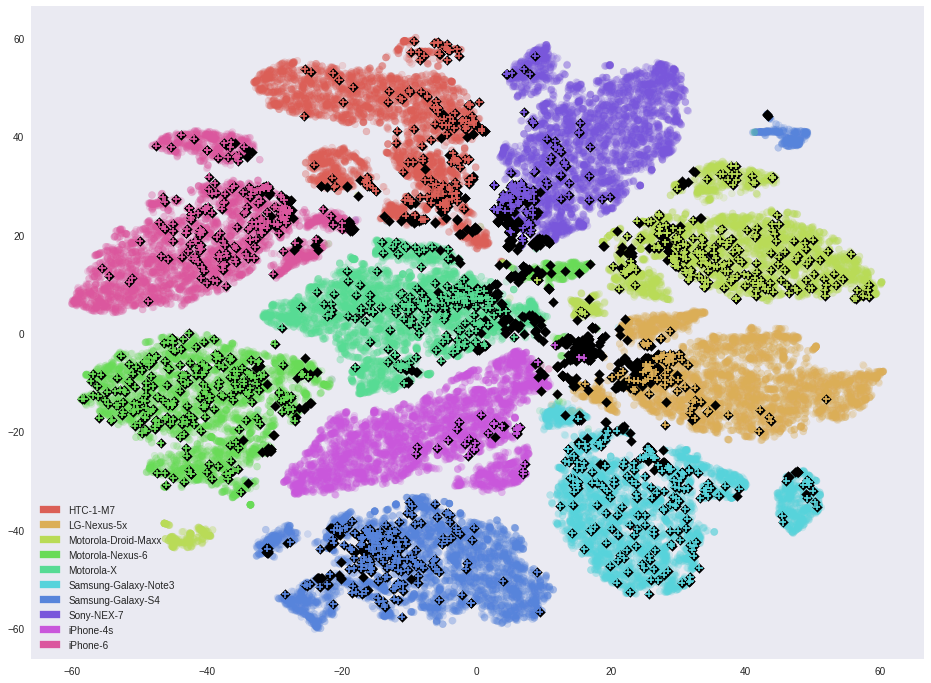

In [3]:
# m_train = np.zeros((len(f2c), 512))
y = []

for ix, fname in tqdm_notebook(enumerate(it.chain(train_files_original, train_files_pseudo)), total=len(f2c)):
#     m_train[ix, :] = np.load(fname)['f_mean']
    y.append(f2c[fname])

la = LabelEncoder().fit(y)    
y = la.transform(y)

# m_test = np.zeros((len(test_files), 512))

# for ix, fname in tqdm_notebook(enumerate(test_files), total=len(test_files)):
#     m_test[ix, :] = np.load(fname)['f_mean']    

# m_svd = TruncatedSVD(n_components=50).fit_transform(np.vstack([m_train, m_test]))

# m_tsne = TSNE(verbose=True).fit_transform(m_svd)
# np.savez('/home/mephistopheies/storage2/data/camera-model-id/tmp/m_tsne.npz', m_tsne=m_tsne)

m_tsne = np.load('/home/mephistopheies/storage2/data/camera-model-id/tmp/m_tsne.npz')['m_tsne']

cols = sns.color_palette('hls', 10)

fig, ax = plt.subplots()

ax.scatter(
    m_tsne[:len(train_files_original), 0], 
    m_tsne[:len(train_files_original), 1],
    c=list(map(lambda ix: cols[ix], y[:len(train_files_original)])),
    marker='o',
    alpha=0.2
)

ax.scatter(
    m_tsne[(len(train_files_original) + len(train_files_pseudo)):, 0], 
    m_tsne[(len(train_files_original) + len(train_files_pseudo)):, 1],
    c='black',
    marker='D'
)

ax.scatter(
    m_tsne[len(train_files_original):(len(train_files_original) + len(train_files_pseudo)), 0], 
    m_tsne[len(train_files_original):(len(train_files_original) + len(train_files_pseudo)), 1],
    c=list(map(lambda ix: cols[ix], y[len(train_files_original):(len(train_files_original) + len(train_files_pseudo))])),
    marker='+',
    alpha=1.0
)

plt.legend(handles=[mpatches.Patch(color=cols[i], label=la.classes_[i]) for i in range(10)])

In [4]:
fkey = 'f_max'
n_splits = 10

pred = {}

m_test_manip = np.stack([np.load(s)[fkey] for s in test_files if 'manip' in s])
m_test_unalt = np.stack([np.load(s)[fkey] for s in test_files if 'unalt' not in s])

for cname in tqdm_notebook(la.classes_):
    

    
    pos_origin_manip = [k for (k, v) in f2c.items() if v == cname and '__aug__' in k]
    m_pos_origin_manip = np.stack([np.load(s)[fkey] for s in pos_origin_manip])
    pos_pseudo_manip = [k for (k, v) in f2c.items() if v == cname and '__aug__' in k]
    m_pos_pseudo_manip = np.stack([np.load(s)[fkey] for s in pos_pseudo_manip])
    neg_origin_manip = [k for (k, v) in f2c.items() if v != cname and '__aug__' in k]
    m_neg_origin_manip = np.stack([np.load(s)[fkey] for s in neg_origin_manip])
    neg_pseudo_manip = [k for (k, v) in f2c.items() if v != cname and '__aug__' in k]
    m_neg_pseudo_manip = np.stack([np.load(s)[fkey] for s in neg_pseudo_manip])
    
    pos_origin_unalt = [k for (k, v) in f2c.items() if v == cname and '__aug__' not in k]
    m_pos_origin_unalt = np.stack([np.load(s)[fkey] for s in pos_origin_unalt])
    pos_pseudo_unalt = [k for (k, v) in f2c.items() if v == cname and '__aug__' not in k]
    m_pos_pseudo_unalt = np.stack([np.load(s)[fkey] for s in pos_pseudo_unalt])
    neg_origin_unalt = [k for (k, v) in f2c.items() if v != cname and '__aug__' not in k]
    m_neg_origin_unalt = np.stack([np.load(s)[fkey] for s in neg_origin_unalt])
    neg_pseudo_unalt = [k for (k, v) in f2c.items() if v != cname and '__aug__' not in k]
    m_neg_pseudo_unalt = np.stack([np.load(s)[fkey] for s in neg_pseudo_unalt])    

    model_manip = LinearSVC(
        penalty='l2',
        dual=False, 
        C=1.0,
        verbose=False,
        max_iter=10000)

    model_manip = model_manip.fit(
        np.vstack([
            m_pos_origin_manip, 
            m_pos_pseudo_manip, 
            m_neg_origin_manip, 
            m_neg_pseudo_manip
        ]),
        np.hstack([
            np.ones(m_pos_origin_manip.shape[0] + m_pos_pseudo_manip.shape[0]), 
            np.zeros(m_neg_origin_manip.shape[0] + m_neg_pseudo_manip.shape[0])
        ])
    )
    
    model_unalt = LinearSVC(
        penalty='l2',
        dual=False, 
        C=1.0,
        verbose=False,
        max_iter=10000)

    model_unalt = model_unalt.fit(
        np.vstack([
            m_pos_origin_unalt, 
            m_pos_pseudo_unalt, 
            m_neg_origin_unalt, 
            m_neg_pseudo_unalt
        ]),
        np.hstack([
            np.ones(m_pos_origin_unalt.shape[0] + m_pos_pseudo_unalt.shape[0]), 
            np.zeros(m_neg_origin_unalt.shape[0] + m_neg_pseudo_unalt.shape[0])
        ])
    )
    
    pred[cname] = {
        'manip': model_manip.predict(m_test_manip),
        'unalt': model_unalt.predict(m_test_unalt)
    }

In [5]:
for k, v in pred.items():
    print(k, v['manip'].sum() + v['unalt'].sum() - 264)

Motorola-X 19.0
Motorola-Nexus-6 44.0
HTC-1-M7 1.0
iPhone-6 -19.0
LG-Nexus-5x -59.0
iPhone-4s -220.0
Samsung-Galaxy-S4 -15.0
Samsung-Galaxy-Note3 -12.0
Motorola-Droid-Maxx 32.0
Sony-NEX-7 -65.0


In [9]:
sum([(v['manip'].sum() + v['unalt'].sum() - 264) for k, v in pred.items()])/len(test_files)

-0.11136363636363636

In [ ]:
# pred_groups = {}
# for k, v in pred.items():
#     pred_groups[k] = [os.path.basename(s)[:-4] for (s, i) in zip(test_files, v) if int(i) == 1]

In [ ]:
#     folder_pos_origin_iter = KFold(n_splits=n_splits).split(m_pos_origin)
#     folder_pos_pseudo_iter = KFold(n_splits=n_splits).split(m_pos_origin)
#     folder_neg_origin_iter = KFold(n_splits=n_splits).split(m_pos_origin)
#     folder_neg_pseudo_iter = KFold(n_splits=n_splits).split(m_pos_origin)
    
#     for ix_iter in range(n_splits):
#         ix_train_pos_origin, ix_test_pos_origin = folder_pos_origin_iter.__next__()
#         ix_train_pos_pseudo, ix_test_pos_pseudo = folder_pos_pseudo_iter.__next__()
#         ix_train_neg_origin, ix_test_neg_origin = folder_neg_origin_iter.__next__()
#         ix_train_neg_pseudo, ix_test_neg_pseudo = folder_neg_pseudo_iter.__next__()
        
#         model = LinearSVC(
#             penalty='l2',
#             dual=False, 
#             C=1.0,
#             verbose=True,
#             max_iter=10000)

#         model = model.fit(
#             np.vstack([
#                 m_pos_origin[ix_train_pos_origin, :], 
#                 m_pos_pseudo[ix_train_pos_pseudo, :], 
#                 m_neg_origin[ix_train_neg_origin, :], 
#                 m_neg_pseudo[ix_train_neg_pseudo, :]
#             ]),
#             np.hstack([
#                 np.ones(ix_train_pos_origin.shape[0] + ix_train_pos_pseudo.shape[0]), 
#                 np.zeros(ix_train_neg_origin.shape[0] + ix_train_neg_pseudo.shape[0])
#             ])
#         )

#         y_pred = model.predict(
#             np.vstack([
#                 m_pos_origin[ix_test_pos_origin, :], 
#                 m_pos_pseudo[ix_test_pos_pseudo, :], 
#                 m_neg_origin[ix_test_neg_origin, :], 
#                 m_neg_pseudo[ix_test_neg_pseudo, :]
#             ]))

#         y_test = np.hstack([
#                 np.ones(ix_test_pos_origin.shape[0] + ix_test_pos_pseudo.shape[0]), 
#                 np.zeros(ix_test_neg_origin.shape[0] + ix_test_neg_pseudo.shape[0])
#             ])

#         score = f1_score(y_test, y_pred) 
#         break